In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.signal import convolve, butter, filtfilt, find_peaks
import copy
import seaborn as sns
import networkx as nx
import pandas as pd

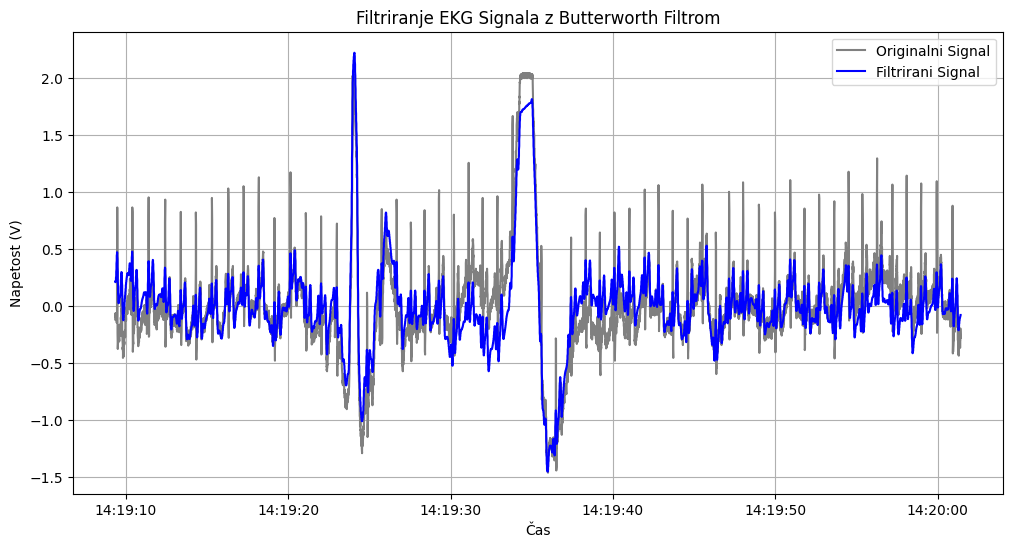

In [71]:

# 1. Del: Naložimo podatke
time_path = "time.txt"
data_path = "data.txt"

# Naložimo časovne žige
with open(time_path, "r", encoding="utf-8") as f:
    timestamps = pd.to_datetime([t.strip() for t in f.readlines()])

# Naložimo vrednosti bitov
with open(data_path, "r", encoding="utf-8") as f:
    bit_values = np.array([int(d.strip()) for d in f.readlines()])

# Pretvorba bitov v napetost (0-1023 vrednosti v napetost 0-5V)
voltage_values = (bit_values / 1023) * 5

# Ustvarimo DataFrame
df = pd.DataFrame({"Time": timestamps, "Bits": bit_values, "Voltage": voltage_values})

# Funkcija za Butterworth filtriranje
def butterworth_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    # Dvojno filtriranje, da odpravimo fazni zamik
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Parametri za Butterworth filter
fs = 1000  # Frekvenca vzorčenja
lowcut = 0.5  # Spodnja meja pasu
highcut = 40  # Zgornja meja pasu

# Pretvorba 'Voltage' v numpy array
voltage_data = np.array(df['Voltage'])

# Filtriraj podatke
df['Filtered_Voltage'] = butterworth_filter(voltage_data, lowcut, highcut, fs)

# Centriranje signalov (odštejemo povprečno vrednost za oba)
df['Centered_Voltage'] = df['Voltage'] - np.mean(df['Voltage'])
df['Centered_Filtered_Voltage'] = df['Filtered_Voltage'] - np.mean(df['Filtered_Voltage'])

# Prikaz rezultata
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Centered_Voltage'], color='gray', label="Originalni Signal")
plt.plot(df['Time'], df['Centered_Filtered_Voltage'], color='blue', label="Filtrirani Signal")
plt.title('Filtriranje EKG Signala z Butterworth Filtrom')
plt.xlabel('Čas')
plt.ylabel('Napetost (V)')
plt.legend()
plt.grid()
plt.show()




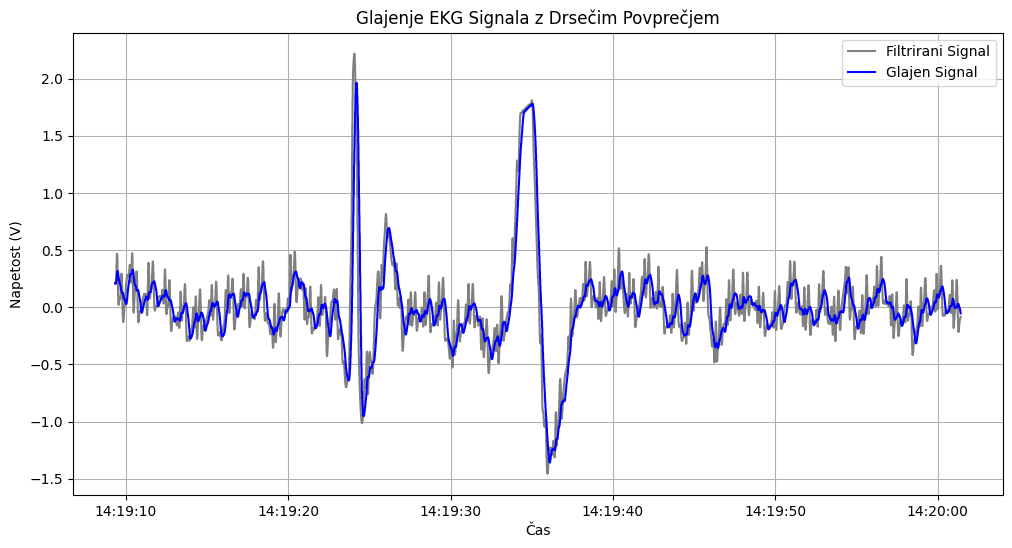

In [72]:
# 2. Del: Glajenje signala z drsečim povprečjem
def moving_average(data, window_size=20):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Glajenje filtriranega signala
df['Smoothed_Voltage'] = moving_average(df['Filtered_Voltage'], window_size=50)

# Centriranje signalov (odštejemo povprečno vrednost za oba)
df['Centered_Voltage'] = df['Voltage'] - np.mean(df['Voltage'])
df['Centered_Smoothed_Voltage'] = df['Smoothed_Voltage'] - np.mean(df['Smoothed_Voltage'])

# Prikaz rezultatov
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Centered_Filtered_Voltage'], color='gray', label="Filtrirani Signal")
plt.plot(df['Time'], df['Centered_Smoothed_Voltage'], color='blue', label="Glajen Signal")
plt.title('Glajenje EKG Signala z Drsečim Povprečjem')
plt.xlabel('Čas')
plt.ylabel('Napetost (V)')
plt.legend()
plt.grid()
plt.show()


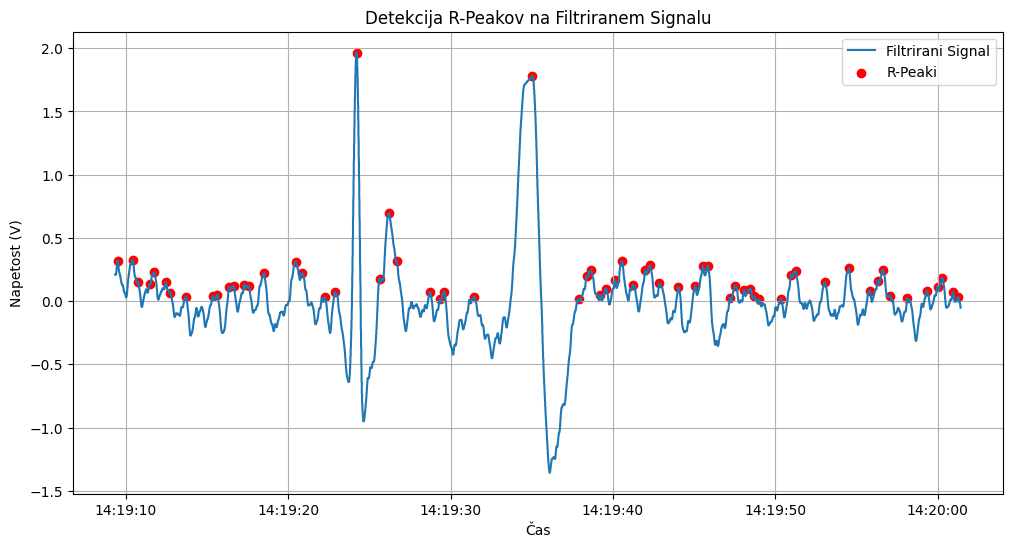

Povprečni BPM: 73.04
Variabilnost srčne frekvence (HRV): 0.65 s


In [73]:
# 3. Del: Analiza signala (detekcija R-peakov, RR intervali, BPM, HRV)

# Prilagodimo parametre za boljšo detekcijo R-peakov
#peaks, _ = find_peaks(df['Centered_Filtered_Voltage'], height=0.1, distance=50)
peaks, _ = find_peaks(df['Centered_Smoothed_Voltage'], height=0.01, distance=40)


# Izračun RR intervalov (v sekundah)
rr_intervals = np.diff(df['Time'].iloc[peaks]).astype('timedelta64[ms]').astype(float) / 1000

# Izračun povprečnega BPM (srčni utrip v minutah)
bpm = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan

# Izračun HRV (standardna devijacija RR intervalov)
hrv = np.std(rr_intervals) if len(rr_intervals) > 1 else np.nan

# Prikaz detektiranih R-peakov
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Centered_Smoothed_Voltage'], label="Filtrirani Signal")
plt.scatter(df['Time'].iloc[peaks], df['Centered_Smoothed_Voltage'].iloc[peaks], color='red', label="R-Peaki")
plt.title('Detekcija R-Peakov na Filtriranem Signalu')
plt.xlabel('Čas')
plt.ylabel('Napetost (V)')
plt.legend()
plt.grid()
plt.show()

"""# Prikaz distribucije RR intervalov
plt.hist(rr_intervals, bins=50, color='blue', alpha=0.7)
plt.title("Distribucija RR Intervalov")
plt.xlabel("RR Interval (sekunde)")
plt.ylabel("Število")
plt.grid()
plt.show()

# Prikaz variabilnosti srčne frekvence (HRV)
plt.plot(rr_intervals, label="RR Intervali")
plt.title("Variabilnost Srčne Frekvence (HRV)")
plt.xlabel("Čas")
plt.ylabel("RR Interval (sekunde)")
plt.grid()
plt.legend()
plt.show()"""

# Ispis rezultatov
print(f"Povprečni BPM: {bpm:.2f}")
print(f"Variabilnost srčne frekvence (HRV): {hrv:.2f} s")
